# Wine quality
[...]
Author: Albert Wildeman

CHECKS
- do not load unnecessary libraries

#JOIN DATASETS OR NOT? talk:
- A. all together, extra binary variable for red/white
- B. all separate (because requirements different for each - valid to try this first and see how similar models are)
- C. Bayesian hierarchical. Just 2 types is not much; would make more sense with say 4+

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import scipy.stats as st
import copy
from IPython.display import display

# SKLearn
from sklearn import decomposition, preprocessing, ensemble, svm, metrics
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV

#from sklearn import linear_model, ensemble, svm, neighbors, preprocessing
#from sklearn.model_selection import cross_val_score

# Graphics
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)

# Set random seed for reproducibility
np.random.seed(0)

# Load data

In [2]:
clrs  = ['red', 'white']
n_clrs = len(clrs)
dfs = [ pd.read_csv("data/winequality-" + clr + ".csv", sep = ';') for clr in clrs]

In [3]:
# See if the columns are identical for red and white wine
dfs[0].columns.identical(dfs[1].columns)

True

In [4]:
# Inspect the column names
dfs[0].columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [5]:
# Generate list of features
feats = dfs[0].drop('quality', axis=1).columns.values
# Get number of features &  (for each color) observations
n_feats = len(feats)
n_obs = [df.shape[0] for df in dfs]

In [6]:
# Determine how many missing values there are
for i_clr, clr in enumerate(clrs):
    print('Missing values in ' + clr + ' wine data: ' + str(dfs[i_clr].isnull().sum().sum()))

Missing values in red wine data: 0
Missing values in white wine data: 0


In [7]:
# None! great news.

## Distribution of quality ratings


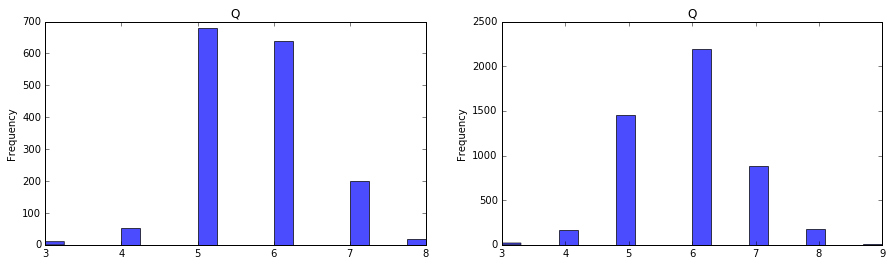

In [8]:
fig = plt.figure(figsize=(15,4))
for i_clr, df in enumerate(dfs):
    ax = plt.subplot2grid((1,2),(0,i_clr))
    #cv_svr.plot(title = "Cross-validation for penalty parameter selection", alpha=0.7, lw=3)
    #plt.xlabel("penalty parameter"); plt.ylabel("MSE") 
    
    df.quality.plot(kind='hist', color='blue', label='Sale Price', bins=20, alpha=0.7)    
    plt.title('Q')

# Log scaling
Inspect distributions of all variables, primarily for normality and outliers.

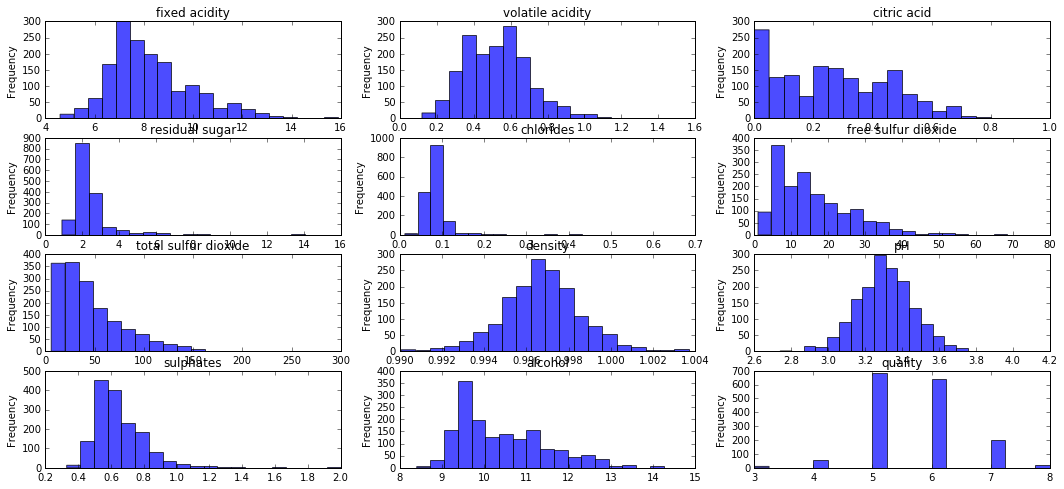

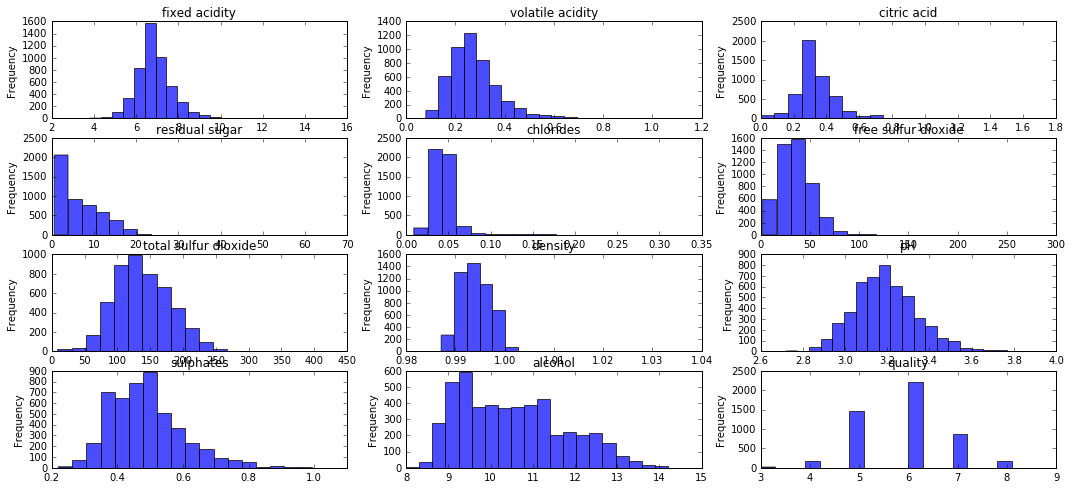

In [9]:
# Diplay histogram of sale prices
for df in dfs:
    fig = plt.figure(figsize=(18,8))
    for i_col, col in enumerate(df.columns.values):
        
        ax = plt.subplot2grid((4,3),divmod(i_col,3))
        df[col].plot(kind='hist', color='blue', label='Sale Price', bins=20, alpha=0.7)    
        plt.title(col)

Make remark about no (extreme) outliers

In [ ]:
# Set features to log-transform
skewed_feats = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 
       'sulphates', 'alcohol']

# log transform

for df in dfs:
    df[skewed_feats] = np.log1p(df[skewed_feats])
    display(df['fixed acidity'][0])


for df in dfs:
    fig = plt.figure(figsize=(18,8))
    for i_col, col in enumerate(df.columns.values):
        
        ax = plt.subplot2grid((4,3),divmod(i_col,3))
        df[col].plot(kind='hist', color='blue', label='Sale Price', bins=20, alpha=0.7)    
        plt.title(col)

## Reduce number of quality ratings to 3

In [10]:
for df in dfs:
    df.quality = (df.quality>4)*1 + (df.quality>7)*1
    print(df.quality.value_counts())

1    1518
0      63
2      18
Name: quality, dtype: int64
1    4535
0     183
2     180
Name: quality, dtype: int64


# Visual feature selection

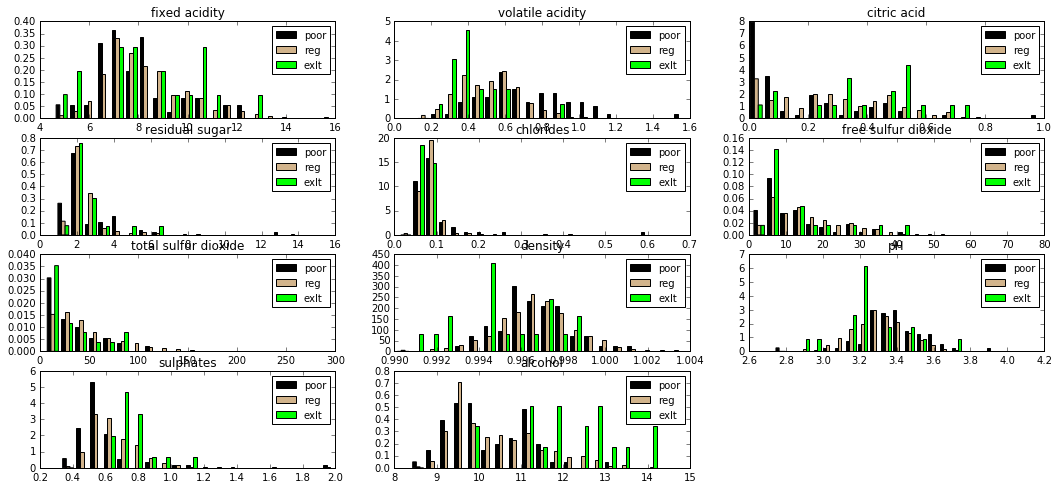

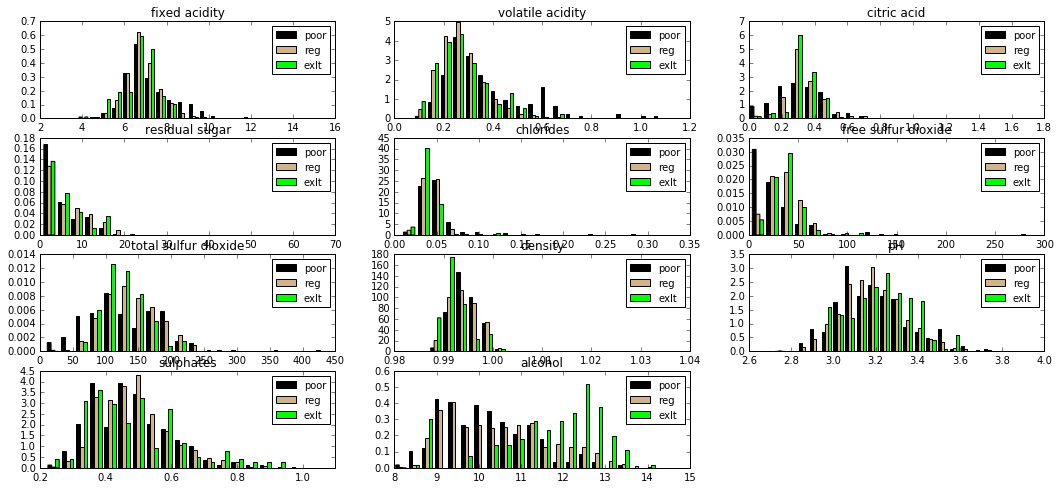

In [11]:
quality_colors = ['black', 'tan', 'lime']
quality_names = ['poor', 'reg', 'exlt']

for i_clr in range(n_clrs):
    # Diplay histogram of sale prices
    fig = plt.figure(figsize=(18,8))
    for i_feat, feat in enumerate(feats):

        ax = plt.subplot2grid((4,3),divmod(i_feat,3))

        #df[col].plot(kind='hist', color='blue', label='Sale Price', bins=20, alpha=0.7)    
        idx = np.where(dfs[i_clr]['quality']==0)[0]

        hist_data = [ dfs[i_clr].loc[np.where(dfs[i_clr]['quality']==0)[0],feat] ,
                      dfs[i_clr].loc[np.where(dfs[i_clr]['quality']==1)[0],feat] ,
                      dfs[i_clr].loc[np.where(dfs[i_clr]['quality']==2)[0],feat]]

        ax.hist(hist_data, 20, normed=1, histtype='bar', color=quality_colors, label=quality_names)
        ax.legend(prop={'size': 10})
        ax.set_title('bars with legend')
        plt.title(feat)

In [12]:
# Select features
sel_feats = [['volatile acidity', 'density', 'sulphates', 'alcohol'], #red wine features
             ['free sulfur dioxide', 'density', 'pH', 'alcohol']] #white wine features

## Normalization: mean-centering and variance scaling
One of the benefits of normalization is that it allows regularized linear models such as Lasso or Ridge Regression to penalize the various feautures evenly.

In [13]:
X = [preprocessing.StandardScaler().fit_transform(dfs[i_clr][sel_feats[i_clr]]) for i_clr in range(n_clrs)]

# Prep data for ML
Split into training (2/3) and test (1/3) sets, and create feature matrices and target vectors as separate entities.

In [14]:
# target vector. Convert to just 3 classes: poor (<5), regular, excellent (>7)
y = [df.quality.values for df in dfs]

In [15]:
# Split into training and test sets
X_trn = [None]*n_clrs; y_trn_multicl = [None]*n_clrs; 
X_tst = [None]*n_clrs; y_tst_multicl = [None]*n_clrs

for i_clr in range(n_clrs):
    X_trn[i_clr], X_tst[i_clr], y_trn_multicl[i_clr], y_tst_multicl[i_clr] = train_test_split(
                                                                         X[i_clr], y[i_clr], test_size=0.33, random_state=1)
# Derive poor and excellent target vectors
y_trn = [[(yy==2)*1 for yy in y_trn_multicl], 
         [(yy==0)*1 for yy in y_trn_multicl],]
y_tst = [[(yy==2)*1 for yy in y_tst_multicl], 
         [(yy==0)*1 for yy in y_tst_multicl],]

criteria = ['excellent', 'poor']
n_criteria = len(criteria)

# Auto-CV ML

In [16]:
# Set up possible values of parameters to optimize over
p_grid = {"C": [0.1, 1, 10, 100],
          "gamma": [.01, .03, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svc = svm.SVC(kernel="rbf", class_weight='balanced')

for i_crit in range(n_criteria):
    for i_clr in range(n_clrs):
        cv = KFold(n_splits=3, shuffle=True, random_state=i_clr)
        
        classifier = GridSearchCV(estimator=svc, param_grid=p_grid, cv=cv, scoring = 'recall')
        classifier.fit(X_trn[i_clr], y_trn[i_crit][i_clr])

        y_pred = classifier.predict(X_tst[i_clr])
        CM = metrics.confusion_matrix(y_tst[i_crit][i_clr], y_pred)
        
        #print results
        print(criteria[i_crit], clrs[i_clr])
        print(classifier.best_estimator_)
        print(CM)

excellent red
SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[[390 133]
 [  0   5]]
excellent white
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[[1103  461]
 [  13   40]]
poor red
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.03, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[[409  96]
 [ 10  13]]
poor white
SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=Tru